# SC 16 - Plot to Plane: Working with NASA and NEON Airborne and Field Datasets

### Ecological Society of America 2025 Conference In-Person Short Course

#### SC 16 - Plot to Plane: Working with NASA and NEON Airborne and Field Datasets
**Friday, August 15, 2025 - 8:00 AM – 11:00 AM EDT:**

The contents of this tutorial were presented at an in-person Short Course held at the Ecological Society of America (ESA) 2025 Conference in Baltimore, Maryland.  Short Course participants had live coding experience within a Managed JupyterHub Service, supported by [2i2c](https://2i2c.org/) and by the [NASA Openscapes Community](https://nasa-openscapes.github.io/). 


# Tutorial:  Mapping Invasive Species Using Supervised Machine Learning and AVIRIS-NG 

## Overview 

In October/November of 2023, the US National Aeronautics and Space Administration (NASA) conducted its first Biodiversity field and airborne campaign across terrestrial and aquatic environments in the South African Greater Cape Floristic Region (GCFR). From 4 airborne instruments (Airborne Visible-Infrared Imaging Spectrometer - Next Generation (AVIRIS-NG), Portable Remote Imaging SpectroMeter (PRISM), Hyperspectral Thermal Emission Spectrometer (HyTES), and Land, Vegetation, and Ice Sensor (LVIS)) the BioSCape Campaign’s remote sensing data products provides an unprecedented level of image spectroscopy from VSWIR to TIR wavelengths as well as full-waveform laser altimeter measurements. Airborne data are supplemented with a rich combination of contemporaneous biodiversity-relevant field observations toward an approach to measure and understand functional, phylogenetic, and taxonomic biological diversity as components of ecosystem function.

In this notebook, we will use existing data of verified land cover and alien species locations to extract spectra from AVIRIS NG surface reflectance data.

**Dataset**
> Brodrick, P. G., Chlus, A. M., Eckert, R., Chapman, J. W., Eastwood, M., Geier, S., Helmlinger, M., Lundeen, S. R., Olson-Duvall, W., Pavlick, R., Rios, L. M., Thompson, D. R., & Green, R. O. (2025). BioSCape: AVIRIS-NG L3 Resampled Reflectance Mosaics, V2 (Version 1). ORNL Distributed Active Archive Center. https://doi.org/10.3334/ORNLDAAC/2427

 
![final_class](images/fynbos_est_XGBOOST60.png)

### Learning Objectives
1. Understand how to inspect and prepare data for machine learning models
2. Train and interpret a machine learning model
3. Apply a trained model to AVIRIS imagery to create alien species maps

## Load Python Modules

In [ ]:
# Modules imported separately - not available at the time of the workshop managed environment 
# !pip3 install --user xvec
# !pip3 install --user shap
# !pip3 install --user xgboost

In [1]:
from os import path
import datetime as dt 
import geopandas as gpd
import s3fs
import pandas as pd
import xarray as xr
from shapely.geometry import box, mapping, Polygon, MultiPolygon
import rioxarray as riox
import numpy as np
import netCDF4 as nc
import hvplot.xarray
import holoviews as hv
import xvec
import shap
import xgboost
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import warnings
import earthaccess
#our functions
from utils import get_first_xr

warnings.filterwarnings('ignore')
hvplot.extension('bokeh')

## Explore Sample Land Type Plot-Level Data
For plot-level training data, we will use a small dataset over the Cape Town Peninsula of South Africa of manually collected invasive plant and land cover label
- `ct_invasive.gpkg`

In [2]:
# let's first create a DataFrame and assign labels to each class

label_df = pd.DataFrame({'LandType': ['Bare ground/Rock','Mature Fynbos', 
              'Recently Burnt Fynbos', 'Wetland', 
              'Forest', 'Pine', 'Eucalyptus' , 'Wattle', 'Water'],
               'class': ['0','1','2','3','4','5','6','7','8']})

label_df

,LandType,class
0,Bare ground/Rock,0
1,Mature Fynbos,1
2,Recently Burnt Fynbos,2
3,Wetland,3
4,Forest,4
5,Pine,5
6,Eucalyptus,6
7,Wattle,7
8,Water,8


In [3]:
# Now let's open the dataset, project to the South African UTM projection also used by the AVIRIS-NG airborne data, and merge it with the label data frame created above.
class_data = gpd.read_file('ct_invasive.gpkg')
# class_data.crs
class_data_utm = (class_data
                 .to_crs("EPSG:32734")
                 .merge(label_df, on='class', how='left')
                 )
class_data_utm

,class,group,geometry,LandType
0,0,2,POINT (264211.767 6198008.161),Bare ground/Rock
1,0,1,POINT (257698.443 6240453.544),Bare ground/Rock
2,0,1,POINT (260264.755 6239108.581),Bare ground/Rock
3,0,1,POINT (258793.622 6239111.697),Bare ground/Rock
4,0,1,POINT (261938.819 6238865.583),Bare ground/Rock
...,...,...,...,...
314,7,2,POINT (262122.203 6228661.57),Wattle
315,3,1,POINT (262105.078 6228827.113),Wetland
316,3,1,POINT (262316.257 6228870.308),Wetland
317,7,1,POINT (262822.284 6241735.006),Wattle


## Summarize and Visualize the Land Types

In [4]:
# examine the number of plots of each land type
class_data_utm.groupby(['LandType']).size()

LandType
Bare ground/Rock         32
Eucalyptus               30
Forest                   34
Mature Fynbos            44
Pine                     36
Recently Burnt Fynbos    32
Water                    32
Wattle                   24
Wetland                  55
dtype: int64

In [5]:
# The group class will be used to determine training and test data
class_data_utm.groupby(['group']).size()

group
1    254
2     65
dtype: int64

In [6]:
# Let's visualize the plot data in an interactive map, with color by class, using a Google satellite basemap
class_data_utm[['LandType', 'geometry']].explore('LandType', tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google')

## Earthdata Authentication

In [7]:
# ask for EDL credentials and persist them in a .netrc file
auth = earthaccess.login(strategy="interactive", persist=True)

## AVIRIS-NG Data over Cape Town Peninsula

In [8]:
# search granules
granules = earthaccess.search_data(
    doi='10.3334/ORNLDAAC/2427', # BioSCape: AVIRIS-NG L3
    granule_name = "AVIRIS-NG*", # exclude geojson tile
)

In [9]:
# print one granule
granules[100]

Collection: {'ShortName': 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 'Version': '2'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.8167, 'Latitude': -33.438}, {'Longitude': 18.8225, 'Latitude': -33.3487}, {'Longitude': 18.7143, 'Latitude': -33.3439}, {'Longitude': 18.7085, 'Latitude': -33.4332}, {'Longitude': 18.8167, 'Latitude': -33.438}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-22T00:00:00Z', 'EndingDateTime': '2023-11-26T23:59:59Z'}}
Size(MB): 6760.123710632324
Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_28_14_QL.tif', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_28_14_UNC.nc', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_28_14_RFL.nc']

In [10]:
vars(granules[100])

{'cloud_hosted': True,
 'uuid': 'a1389c37-ec21-405b-9203-815811ec64bb',
 'render_dict': Collection: {'ShortName': 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 'Version': '2'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 18.8167, 'Latitude': -33.438}, {'Longitude': 18.8225, 'Latitude': -33.3487}, {'Longitude': 18.7143, 'Latitude': -33.3439}, {'Longitude': 18.7085, 'Latitude': -33.4332}, {'Longitude': 18.8167, 'Latitude': -33.438}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-22T00:00:00Z', 'EndingDateTime': '2023-11-26T23:59:59Z'}}
 Size(MB): 6760.123710632324
 Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_28_14_QL.tif', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_28_14_UNC.nc', 'https://data.ornldaac.earthdata.nasa.gov/protected/biosc

In [11]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    ltln = gpoly[0]["Boundary"]["Points"]
    return Polygon([(p["Longitude"], p["Latitude"]) for p in ltln])

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # creates polygon geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    
AVNG_Coverage = convert_list_gdf(granules)
AVNG_Coverage[['native-id', 'geometry']].explore(tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google')

## Open a single AVIRIS-NG Reflectance file to inspect the data

- **`xarray`** is an open source project and Python package that introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays

In [12]:
# search granules that spatially intersects with class_data
single_granule = earthaccess.search_data(
    doi='10.3334/ORNLDAAC/2427', # BioSCape: AVIRIS-NG L3
    granule_name = "AVIRIS-NG_BIOSCAPE_V02_L3_36_11*", # select only one file
)
single_granule[0].data_links(access="direct")

['s3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_36_11_QL.tif',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_36_11_UNC.nc',
 's3://ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_36_11_RFL.nc']

In [13]:
# earthaccess open
fh = earthaccess.open(single_granule)
fh

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_36_11_QL.tif>,
 <File-like object HTTPFileSystem, https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_36_11_UNC.nc>,
 <File-like object HTTPFileSystem, https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_36_11_RFL.nc>]

In [14]:
def separate_granule_type(fo):
    """separating granules by type"""
    return ([f for f in fo if f.path.endswith("_RFL.nc")],
            [f for f in fo if f.path.endswith("_QL.tif")],
            [f for f in fo if f.path.endswith("_UNC.nc")])
rfl_f, ql_f, unc_f = separate_granule_type(fh)

In [15]:
# plot a single file netcdf
rfl_netcdf = xr.open_datatree(rfl_f[0],
                              engine='h5netcdf', chunks={})
rfl_netcdf = rfl_netcdf.reflectance.to_dataset()
rfl_netcdf = rfl_netcdf.reflectance.where(rfl_netcdf.reflectance>0)
rfl_netcdf

<xarray.DataArray 'reflectance' (wavelength: 425, northing: 2000, easting: 2000)> Size: 7GB
dask.array<where, shape=(425, 2000, 2000), dtype=float32, chunksize=(10, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * easting     (easting) float64 16kB 7.9e+05 7.9e+05 7.9e+05 ... 8e+05 8e+05
  * northing    (northing) float64 16kB 8.3e+05 8.3e+05 ... 8.2e+05 8.2e+05
  * wavelength  (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
Attributes:
    _QuantizeBitGroomNumberOfSignificantDigits:  5
    long_name:                                   Mosaiced Hemispherical Direc...
    grid_mapping:                                transverse_mercator
    orthorectified:                              True

### Plot just a red reflectance

In [16]:
h = rfl_netcdf.sel({'wavelength': 660},method='nearest').hvplot('easting', 'northing',
                                                      rasterize=True, data_aspect=1,
                                                      cmap='magma',frame_width=400,clim=(0,0.3))
h

BokehModel(combine_events=True, render_bundle={'docs_json': {'841fe7c6-6eea-481f-807b-14c2e5a481ba': {'version…

### Plot a quicklook image

In [17]:
# plot a single file geotif
ql_tif = xr.open_dataset(ql_f[0], engine='rasterio')
h = ql_tif.hvplot.rgb('x', 'y', bands='band', rasterize=True, data_aspect=1, frame_width=400)
h

BokehModel(combine_events=True, render_bundle={'docs_json': {'26f4b5a2-402c-457f-b06e-dee8eb405906': {'version…

## Select the AVIRIS-NG Flight Line data to selected parameters
For our analysis demonstration in this Notebook, we'll narrow the flight tiles to the area of the Cape Penisula.

In [18]:
# search granules that spatially intersects with class_data
granules_cp = earthaccess.search_data(
    doi='10.3334/ORNLDAAC/2427', # BioSCape: AVIRIS-NG L3
    bounding_box = tuple(class_data.total_bounds),
    granule_name = "AVIRIS-NG*", # exclude geojson tile
)

In [19]:
AVNG_Coverage = convert_list_gdf(granules_cp)
AVNG_Coverage[['native-id', 'geometry']].explore('native-id', tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', attr='Google')

### Extract Spectra for each Land Plot

Now that we are familiar with the data, we want to get the AVIRIS spectra at each label location. Below is a function that does this and returns the result as a xarray

In [20]:
f_cp = earthaccess.open(granules_cp)
rfl_f, ql_f, unc_f = separate_granule_type(f_cp)
AVNG_CP = AVNG_Coverage.to_crs("EPSG:32734")
ds_all =[]
for rfl in rfl_f:
    native_id = path.basename(rfl.path)[:-7]
    geof = AVNG_CP[AVNG_CP["native-id"]==native_id].geometry
    points = class_data_utm.clip(geof)
    n_points = points.shape[0]
    if n_points:
        print(f'got {n_points} point from {native_id}')
        ds = xr.open_datatree(rfl, engine='h5netcdf', chunks={})
        points = points.to_crs(ds.transverse_mercator.crs_wkt)
        ds_all.append(ds.reflectance.to_dataset().xvec.extract_points(points['geometry'], 
                                                                x_coords="easting", 
                                                                y_coords="northing",
                                                                index=True))
ds_all = xr.concat(ds_all, dim='file')

QUEUEING TASKS | :   0%|          | 0/51 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/51 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/51 [00:00<?, ?it/s]

got 40 point from AVIRIS-NG_BIOSCAPE_V02_L3_37_11
got 3 point from AVIRIS-NG_BIOSCAPE_V02_L3_37_12
got 26 point from AVIRIS-NG_BIOSCAPE_V02_L3_38_11
got 3 point from AVIRIS-NG_BIOSCAPE_V02_L3_35_10
got 11 point from AVIRIS-NG_BIOSCAPE_V02_L3_36_12
got 7 point from AVIRIS-NG_BIOSCAPE_V02_L3_39_12
got 22 point from AVIRIS-NG_BIOSCAPE_V02_L3_38_12
got 67 point from AVIRIS-NG_BIOSCAPE_V02_L3_36_11
got 32 point from AVIRIS-NG_BIOSCAPE_V02_L3_34_11
got 4 point from AVIRIS-NG_BIOSCAPE_V02_L3_39_11
got 104 point from AVIRIS-NG_BIOSCAPE_V02_L3_35_11


In [21]:
ds_all

<xarray.Dataset> Size: 6MB
Dimensions:      (file: 11, wavelength: 425, geometry: 319)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * geometry     (geometry) object 3kB POINT (797172.1686535219 811982.435141...
    index        (file, geometry) float64 28kB 134.0 133.0 132.0 ... 2.0 300.0
Dimensions without coordinates: file
Data variables:
    fwhm         (file, wavelength) float32 19kB dask.array<chunksize=(1, 425), meta=np.ndarray>
    reflectance  (file, wavelength, geometry) float32 6MB dask.array<chunksize=(1, 10, 3), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=PROJCS["unnamed",GEOGCS["Ellipse Based",DATUM["Ellipse Based",SPHE ...)

In [22]:
ds = get_first_xr(ds_all)
ds

<xarray.Dataset> Size: 549kB
Dimensions:      (wavelength: 425, index: 319)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
    geometry     (index) object 3kB POINT (797172.1686535219 811982.435141402...
  * index        (index) int64 3kB 134 133 132 247 110 109 ... 77 16 305 2 300
Data variables:
    reflectance  (index, wavelength) float32 542kB dask.array<chunksize=(3, 10), meta=np.ndarray>

This data set just has the spectra. We need to merge with point data to add labels

In [23]:
class_xr =class_data_utm[['class','group']].to_xarray()
ds = ds.merge(class_xr.astype(int),join='left')
ds

<xarray.Dataset> Size: 554kB
Dimensions:      (wavelength: 425, index: 319)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * index        (index) int64 3kB 134 133 132 247 110 109 ... 77 16 305 2 300
    geometry     (index) object 3kB POINT (797172.1686535219 811982.435141402...
Data variables:
    reflectance  (index, wavelength) float32 542kB dask.array<chunksize=(3, 10), meta=np.ndarray>
    class        (index) int64 3kB 6 5 5 8 3 3 1 2 3 3 2 ... 1 1 0 8 0 3 0 0 0 4
    group        (index) int64 3kB 1 2 1 1 1 1 2 1 1 2 1 ... 1 1 1 1 1 2 1 1 1 1

We have defined all the operations we want, but becasue of xarrays lazy computation, the calculations have not yet been done. We will now force it to perform this calculations. We want to keep the result in chunks, so we use .persist() and not .compute(). This should take approx 2 - 3 mins

In [24]:
##  DUE TO RUN TIME LENGTH, WE WILL NOT RUN THIS IN THE WORKSHOP - For this workshop, we HAVE SAVED THIS OUTPUT (dsp.nc) and it is available FOR NEXT STEP
# with ProgressBar():
#     dsp = ds.persist()

In [25]:
# dsp.drop_vars('geometry').to_netcdf('~/shared-public/data/dsp.nc')
dsp = xr.open_dataset('dsp.nc')
dsp

<xarray.Dataset> Size: 552kB
Dimensions:      (index: 319, wavelength: 425)
Coordinates:
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
  * index        (index) int64 3kB 134 133 132 247 110 109 ... 77 16 305 2 300
Data variables:
    reflectance  (index, wavelength) float32 542kB ...
    class        (index) int64 3kB ...
    group        (index) int64 3kB ...

### Inspect AVIRIS spectra

In [26]:
# recall the class types
label_df

,LandType,class
0,Bare ground/Rock,0
1,Mature Fynbos,1
2,Recently Burnt Fynbos,2
3,Wetland,3
4,Forest,4
5,Pine,5
6,Eucalyptus,6
7,Wattle,7
8,Water,8


In [27]:
dsp_plot = dsp.where(dsp['class']==5, drop=True)
h = dsp_plot['reflectance'].hvplot.line(x='wavelength',by='index',
                                    color='green', alpha=0.5,legend=False)
h

:NdOverlay   [index]
   :Curve   [wavelength]   (Mosaiced Hemispherical Directional Reflectance Factor)

> At this point in a real machine learning workflow, you should closely inspect the spectra you have for each class. Do they make sense? Are there some spectra that look weird? You should re-evaluate your data to make sure that the assigned labels are true. This is a very important step

#### Prep data for ML model

As you will know, not all of the wavelengths in the data are of equal quality, some will be degraded by atmospheric water absorption features or other factors. We should remove the bands from the analysis that we are not confident of. Probably the best way to do this is to use the uncertainties provided along with the reflectance files. We will simply use some prior knowledge to screen out the worst bands.

In [28]:
wavelengths_to_drop = dsp.wavelength.where(
    (dsp.wavelength < 450) |
    (dsp.wavelength >= 1340) & (dsp.wavelength <= 1480) |
    (dsp.wavelength >= 1800) & (dsp.wavelength <= 1980) |
    (dsp.wavelength > 2400), drop=True
)

# Use drop_sel() to remove those specific wavelength ranges
dsp = dsp.drop_sel(wavelength=wavelengths_to_drop)

mask = (dsp['reflectance'] > -1).all(dim='wavelength')  # Create a mask where all values along 'z' are non-negative
dsp = dsp.sel(index=mask)
dsp

<xarray.Dataset> Size: 424kB
Dimensions:      (index: 319, wavelength: 325)
Coordinates:
  * wavelength   (wavelength) float32 1kB 452.3 457.3 ... 2.391e+03 2.396e+03
  * index        (index) int64 3kB 134 133 132 247 110 109 ... 77 16 305 2 300
Data variables:
    reflectance  (index, wavelength) float32 415kB 0.02169 0.02095 ... 0.04408
    class        (index) int64 3kB 6 5 5 8 3 3 1 2 3 3 2 ... 1 1 0 8 0 3 0 0 0 4
    group        (index) int64 3kB ...

Next we will normalize the data, there are a number of difference normalizations to try. In a ML workflow you should try a few and see which work best. We will only use a **`Brightness Normalization`**. In essence, we scale the reflectance of each wavelength by the total brightness of the spectra. 

In applications like hyperspectral imaging or spectral data analysis, brightness normalization helps eliminate differences caused by varying magnitudes of the reflectance. This ensures that the analysis of spectral features focuses entirely on the shape or characteristics of the spectra, independent of overall brightness or intensity.

The reflectance values are scaled to create a consistent baseline for comparing spectra or features.

In [29]:
# Calculate the L2 norm along the 'wavelength' dimension
l2_norm = np.sqrt((dsp['reflectance'] ** 2).sum(dim='wavelength'))  # the square root of the sum of the squares of the values across dim wavelength

# Normalize the reflectance by dividing by the L2 norm
dsp['reflectance'] = dsp['reflectance'] / l2_norm  # removes brightness differences due to varying magnitudes and ensures that 
                                                   # the reflectance values across wavelengths are unit-normalized.

Plot the new, clean spectra

In [30]:
dsp_norm_plot = dsp.where(dsp['class']==5, drop=True)
h = dsp_norm_plot['reflectance'].hvplot.line(x='wavelength',by='index',
                                         color='green',ylim=(-0.01,0.15),alpha=0.5,legend=False)
h

:NdOverlay   [index]
   :Curve   [wavelength]   (reflectance)

### Train and evaluate the ML model

We will be using a model called **`xgboost`**. There are many different kinds of ML models. `xgboost`, or Extreme Gradient Boosting, is a class of models called gradient boosted trees, related to random forests. When used for classification, random forests work by creating multiple decision trees, each trained on a random subset of the data and features, and then averaging their predictions to improve accuracy and reduce overfitting. 

Gradient boosted trees differ in that they build trees sequentially, with each new tree focusing on correcting the errors of the previous ones. This sequential approach allows `xgboost` to create highly accurate models by iteratively refining predictions and addressing the weaknesses of earlier trees.

Import the Machine Learning libraries we will use.

In [31]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

Our dataset has a label indicating which set (training or test), our data belong to. We wil use this to split it

In [32]:
# recall groups
class_data_utm.groupby(['group']).size()

group
1    254
2     65
dtype: int64

In [33]:
class_data_utm.crs

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Let's separate the data into training and testing subsets for model training and evaluation, respectively

In [34]:
dtrain = dsp.where(dsp['group']==1,drop=True)  # the training set
dtest = dsp.where(dsp['group']==2,drop=True)   # the evaluation (testing) set

#create separte datasets for labels and features
y_train = dtrain['class'].values.astype(int)  # the variable 'class' is extracted from both the training (dtrain) and testing (dtest) datasets
y_test = dtest['class'].values.astype(int)
X_train = dtrain['reflectance'].values        # The variable 'reflectance' is extracted from both the training (dtrain) and testing (dtest) datasets
X_test = dtest['reflectance'].values          # .values: Converts the 'reflectance' variable into a NumPy array for the machine learning models

#### Train ML model
The steps we will go through to train the model are:

- First, we define the hyperparameter grid. Initially, we set up a comprehensive grid (param_grid) with multiple values for several hyperparameters of the XGBoost model. 

- Next, we create an XGBoost classifier object using the XGBClassifier class from the XGBoost library.

We then set up the GridSearchCV object using our defined XGBoost model and the hyperparameter grid. GridSearchCV allows us to perform an exhaustive search over the specified hyperparameter values to find the optimal combination that results in the best model performance. We choose a 5-fold cross-validation strategy (cv=5), meaning we split our training data into five subsets to validate the model's performance across different data splits. We use accuracy as our scoring metric to evaluate the models.

After setting up the grid search, we fit the GridSearchCV object to our training data (X_train and y_train). This process involves training multiple models with different hyperparameter combinations and evaluating their performance using cross-validation. Our goal is to identify the set of hyperparameters that yields the highest accuracy.

Once the grid search completes, we print out the best set of hyperparameters and the corresponding best score. The grid_search.best_params_ attribute provides the combination of hyperparameters that achieved the highest cross-validation accuracy, while the grid_search.best_score_ attribute shows the corresponding accuracy score. Finally, we extract the best model (best_model) from the grid search results. This model is trained with the optimal hyperparameters and is ready for making predictions or further analysis in our classification task.

This will take approx __30 seconds__

In [35]:
# Define the hyperparameter grid
param_grid = {                   # param_grid dictionary specifies the hyperparameters to be tuned and the values to be tested for each hyperparameter
    'max_depth': [5],            # maximum depth of a tree, controlling the complexity of the individual tree
    'learning_rate': [0.1],      # rate at which the model updates weights during training
    'subsample': [0.75],         # fraction of the training data to randomly sample for each tree
    'n_estimators' : [50,100]    # number of boosting rounds (trees) in the ensemble
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier(tree_method='hist')

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)  # the combination of hyperparameters that achieved the highest accuracy during cross-validation
print("Best score: ", grid_search.best_score_)    # the cross-validation accuracy score corresponding to the best hyperparameters
best_model = grid_search.best_estimator_    # Retrieves the trained model (XGBoost classifier) corresponding to the best combination of hyperparameters 
                                            # found during the grid search

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.75}
Best score:  0.6376470588235295


### Evaluate model performance

We will use our best model to predict the classes of the test data  Then, we calculate the F1 score using f1_score, which balances precision and recall, and print it to evaluate overall performance.

Next, we assess how well the model performs for predicting Pine trees by calculating its precision and recall. Precision measures the accuracy of the positive predictions.  It answers the question, "Of all the instances we labeled as Pines, how many were actually Pines?". Recall measures the model's ability to identify all actual positive instances. It answers the question, "Of all the actual Pines, how many did we correctly identify?". You may also be familiar with the terms Users' and Producers' Accuracy. Precision  = User' Accuracy, and Recall = Producers' Accuracy.

Finally, we create and display a confusion matrix to visualize the model's prediction accuracy across all classes

In [36]:
label_df

,LandType,class
0,Bare ground/Rock,0
1,Mature Fynbos,1
2,Recently Burnt Fynbos,2
3,Wetland,3
4,Forest,4
5,Pine,5
6,Eucalyptus,6
7,Wattle,7
8,Water,8


Accuracy: 0.6615384615384615
F1 Score (weighted): 0.6568699274581629
Precision for Class 6: 0.5
Recall for Class 6: 0.7142857142857143


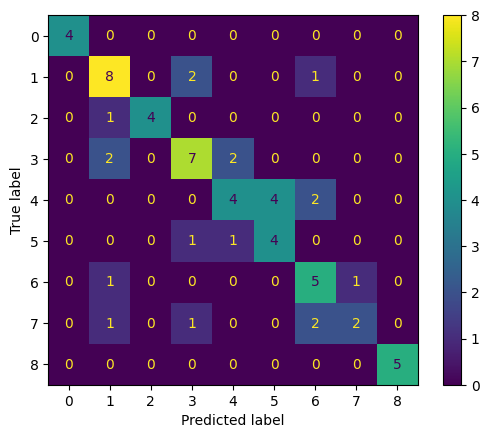

In [37]:
y_pred = best_model.predict(X_test)

# Step 2: Calculate acc and F1 score for the entire dataset
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' accounts for class imbalance
print(f"F1 Score (weighted): {f1}")

# Step 3: Calculate precision and recall for class 6 (Eucalyptus)
precision_class_6 = precision_score(y_test, y_pred, labels=[6], average='macro', zero_division=0)
recall_class_6 = recall_score(y_test, y_pred, labels=[6], average='macro', zero_division=0)

print(f"Precision for Class 6: {precision_class_6}")
print(f"Recall for Class 6: {recall_class_6}")

# Step 4: Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()
plt.show()

- `Accuracy` provides a general measure of how well the classifier performs overall
    - It is the Number of Correct Predictions divided by the Total Number of Samples
- `Precision` measures the proportion of true positive predictions relative to the total predicted positives for a class
- `Confusion Matrix` Computes the matrix summarizing the classifier’s predictions. Each row corresponds to the true label, and each column corresponds to the predicted label. The diagonal elements represent correctly classified samples, while off-diagonal elements represent misclassifications

### Predict over an example AVIRIS scene

We now have a trained model and are ready to deploy it to generate predictions across an entire AVIRIS scene and map the distribution of invasive plants. This involves handling a large volume of data, so we need to write the code to do this intelligently. We will accomplish this by applying the `.predict()` method of our trained model in parallel across the chunks of the AVIRIS xarray. The model will receive one chunk at a time so that the data is not too large, but it will be able to perform this operation in parallel across multiple chunks, and therefore will not take too long.

This model was only trained on data covering natural vegetaton in the Cape Peninsula, It is important that we only predict in the areas that match our training data. We will therefore filter to scenes that cover the Cape Peninsula.

Here is the function that we will actually apply to each chunk. Simple really. The hard work is getting the data into and out of this function
- `chunk` - a portion of input data (e.g., a subset of the dataset) The function processes chunks for efficient computation and prediction
- `model` - This is our trained machine learning model

In [38]:
def predict_on_chunk(chunk, model):
    probabilities = model.predict_proba(chunk)
    return probabilities

Now we define the funciton that takes as input the path to the AVIRIS file and pass the data to the predict function. This is composed of 4 parts:

- Part 1: Opens the AVIRIS data file using xarray and sets a condition to identify valid data points where reflectance values are greater than zero.

- Part 2: Applies all the transformations that need to be done before the data goes to the model. It puts the spatial dimensions (x and y) into a single dimension, filters wavelengths, and normalizes the reflectance data.

- Part 3: Applies the machine learning model to the normalized data in parallel, predicting class probabilities for each data point using xarray's apply_ufunc method. Most of the function invloves defining what to do with the dimensions of the old dataset and the new output

- Part 4: Unstacks the data to restore its original dimensions, sets spatial dimensions and coordinate reference system (CRS), clips the data, and transposes the data to match expected formats before returning the results.

In [39]:
def predict_xr(file,geometries):

    rfl_f, ql_f, unc_f = separate_granule_type(file)
    native_id = path.basename(rfl_f[0].path)[:-7]
    
    #part 1 - opening file
    #open the file
    print(f'file: {rfl_f[0]}')
    ds = xr.open_datatree(rfl_f[0], engine='h5netcdf', chunks='auto')
    
    #get the geometries of the protected areas for masking
    ds_crs = ds.transverse_mercator.crs_wkt
    geometries = geometries[geometries["native-id"]==native_id].to_crs(ds_crs).geometry.apply(mapping)
    # geometries = geometries.to_crs(ds_crs).geometry.apply(mapping)
    
    #condition to use for masking no data later
    condition = (ds['reflectance'] > -1).any(dim='wavelength')
    
    #stack the data into a single dimension. This will be important for applying the model later
    ds = ds.reflectance.to_dataset().stack(sample=('easting','northing'))
    
    #part 2 - pre-processing
    #remove bad wavelenghts
    wavelengths_to_drop = ds.wavelength.where(
        (ds.wavelength < 450) |
        (ds.wavelength >= 1340) & (ds.wavelength <= 1480) |
        (ds.wavelength >= 1800) & (ds.wavelength <= 1980) |
        (ds.wavelength > 2400), drop=True
    )
    # Use drop_sel() to remove those specific wavelength ranges
    ds = ds.drop_sel(wavelength=wavelengths_to_drop)
    
    #normalise the AVIRIS data
    l2_norm = np.sqrt((ds['reflectance'] ** 2).sum(dim='wavelength'))
    ds['reflectance'] = ds['reflectance'] / l2_norm
    
     
    #part 3 - apply the model over chunks
    result = xr.apply_ufunc(
        predict_on_chunk,
        ds['reflectance'].chunk(dict(wavelength=-1)),
        input_core_dims=[['wavelength']],    # input dim with features
        output_core_dims=[['class']],        # name for the new output dim
        exclude_dims=set(('wavelength',)),   # dims to drop in result
        output_sizes={'class': 9},           # length of the new dimension
        output_dtypes=[np.float32],
        dask="parallelized",
        kwargs={'model': best_model}
    )
    
    #part 4 - post-processing
    result = result.where((result >= 0) & (result <= 1), np.nan)  # valid values
    result = result.unstack('sample')                             # remove the stack
    result = result.rio.set_spatial_dims(x_dim='easting',y_dim='northing') # set the spatial dims
    result = result.rio.write_crs(ds_crs)                         # set the CRS
    result = result.rio.clip(geometries)                          # clip to the protected areas and no data
    result = result.transpose('class', 'northing', 'easting')     # transpose the data - rio expects it this way
    
    return result   

Let's test that it works on a single file before we run it through 100s of GB of data.

In [40]:
#test  = predict_xr(earthaccess.open(single_granule),AVNG_sapad)
test  = predict_xr(earthaccess.open(single_granule),AVNG_Coverage)
#test

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

file: <File-like object HTTPFileSystem, https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_36_11_RFL.nc>


The AVIRIS tile is **AVIRIS-NG_BIOSCAPE_V02_L3_36_11_RFL.nc**

In [41]:
# Again, recall the labels and LandType classes
label_df

,LandType,class
0,Bare ground/Rock,0
1,Mature Fynbos,1
2,Recently Burnt Fynbos,2
3,Wetland,3
4,Forest,4
5,Pine,5
6,Eucalyptus,6
7,Wattle,7
8,Water,8


In [42]:
# Reproject the dataset to WGS84 (EPSG:4326)
test = test.rio.reproject("EPSG:4326", nodata=np.nan)

In [43]:


# Enhanced Plot with Titles and Styling
h = test.isel({'class': 1}).hvplot(
    tiles=hv.element.tiles.EsriImagery(),   # Use Esri Imagery as a tile background
    project=True,                          # Project the data to work seamlessly with the background
    rasterize=True,                        # Rasterize for efficient plotting
    clim=(0.01, 1),                           # Define color limits to focus on the range of interest
    cmap='magma',                          # Colormap for better visualization
    frame_width=800,                       # Increase the width for better spatial resolution
    data_aspect=1,                         # Maintain a realistic and proportional aspect ratio
    alpha=0.5,                             # Adjust opacity for optimal visualization
    colorbar=True                          # Enable the colorbar (hvplot handles this properly)
)

# Add Descriptive Titles (handled internally by hvplot)
h = h.opts(
    title="Class 1: Mature Fynbos - Probability Mapping"  # Set title directly using Holoviews options
)
h 


BokehModel(combine_events=True, render_bundle={'docs_json': {'41632b07-60d9-48fb-be30-5d893c1b6386': {'version…

ML models typically provide a single prediction of the most likely outcomes. You can also get probability-like scores (values from 0 to 1) from these models, but they are not true probabilities. If the model gives you a score of 0.6, that means it is more likely than a prediction of 0.5, and less likely than 0.7. However, it does not mean that in a large sample your prediction would be right 60 times out of 100. To get calibrated probabilities from our models, we have to apply additional steps. We can also get a set of predictions from models rather than a single prediction, which reflects the model's true uncertainty using a technique called conformal predictions. Read more about conformal prediction for geospatial machine learning in this amazing paper:

[Singh, G., Moncrieff, G., Venter, Z., Cawse-Nicholson, K., Slingsby, J., & Robinson, T. B. (2024). Uncertainty quantification for probabilistic machine learning in earth observation using conformal prediction. Scientific Reports, 14(1), 16166.](https://www.nature.com/articles/s41598-024-65954-w)

### Additional steps in the BioSCape Workshop Tutorial
For the length of this workshop, we cannot cover all steps that were part of a 3-day BioSCape Cape Town Workshop.  Links are provided here:

**`8.2.1.8. Interpret and understand ML model`**

- https://ornldaac.github.io/bioscape_workshop_sa/tutorials/Machine_Learning/Invasive_AVIRIS.html#interpret-and-understand-ml-model

### Final steps of the full ML classification are time intensive and are not described in this workshop.  

Steps in BioSCape Cape Town Workshop Tutorial

[``8.2.1.10. Merge and mosaic results``](https://ornldaac.github.io/bioscape_workshop_sa/tutorials/Machine_Learning/Invasive_AVIRIS.html#merge-and-mosaic-results)



### CREDITS:  

Find all of the October 2025 BioSCape Data Workshop Materials/Notebooks

- https://ornldaac.github.io/bioscape_workshop_sa/intro.html

This Notebook is an adaption of **Glenn Moncrieff**'s BioSCape Data Workshop Notebook:  [**Mapping invasive species using supervised machine learning and AVIRIS-NG**](https://ornldaac.github.io/bioscape_workshop_sa/tutorials/Machine_Learning/Invasive_AVIRIS.html)
- This Notebook accesses and uses an updated version of AVIRIS-NG data with improved corrections and that are in netCDF file formats

Glenn's lesson borrowed from:

- [``Land cover mapping example on Microsoft Planetary Computer``](https://planetarycomputer.microsoft.com/docs/tutorials/landcover)